In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

In [2]:
# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat

### file hierarchy and database connection vars

In [3]:
# # directory & file hierarchy
# iterationName = 'cdm_run_v3'
# exp_path = 'museumstation'
# analysis_dir = os.getcwd()
# exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
# ##
# sketch_dir = os.path.join(analysis_dir,'sketches')
# if not os.path.exists(sketch_dir):
#     os.makedirs(sketch_dir)
# ## dir where we can keep all sketches not binned by category    


In [5]:
# set vars 
auth = pd.read_csv('../auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v4']

### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [6]:
iterationName = 'cdm_run_v4'
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(all_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 766 valid sessions from cdm_run_v4.
We currently have 4876 total drawings from cdm_run_v4.
The last drawing was made at 2018-11-01T18:21:39.264Z.


In [7]:
experiment_name = 'testing'
iterationName = 'cdm_run_v4'
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find().distinct('sessionId')
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 766 valid sessions from cdm_run_v4.
We currently have 4876 total drawings from cdm_run_v4.
The last drawing was made at 2018-11-01T18:21:39.264Z.


In [28]:
coll = db['cdm_run_v3']
iterationName = 'cdm_run_v3'
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
image_recs_all = coll.find({'$and': [{'dataType':'finalImage'}]})
numImages = image_recs_all.count()
lastImage = image_recs_all[numImages - 1]
lastestDate = lastImage['date']

print 'We currently have {} valid sessions from {}.'.format(len(all_sessions), iterationName)
print 'We currently have {} total drawings from {}.'.format(numImages, iterationName)
print 'The last drawing was made at {}.'.format(lastestDate)

We currently have 4412 valid sessions from cdm_run_v3.
We currently have 25160 total drawings from cdm_run_v3.
The last drawing was made at 2018-09-04T21:33:25.905Z.


### How many of these drawings are from kids and not on practice trials?

In [8]:
image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'square'}]})
print 'We currently have {} square images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'shape'}]})
print 'We currently have {} shape images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':'this square'}]})
print 'We currently have {} circle images from kids in {}.'.format(image_recs_kids.count(), iterationName)

image_recs_kids = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}}]})
print 'We currently have {} TOTAL images from kids in {}.'.format(image_recs_kids.count(), iterationName)


We currently have 716 square images from kids in cdm_run_v4.
We currently have 582 shape images from kids in cdm_run_v4.
We currently have 510 circle images from kids in cdm_run_v4.
We currently have 4524 TOTAL images from kids in cdm_run_v4.


In [9]:
image_recs_kids_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from kids in {}.'.format(image_recs_kids_not_practice.count(), iterationName)

We currently have 3226 non-practice trials from kids in cdm_run_v4.


In [10]:
image_recs_adults_not_practice = coll.find({'$and': [{'dataType':'finalImage'},{'age': 'adult'},{'category':{"$nin": ['square','this circle','shape']}}]})
print 'We currently have {} non-practice trials from adults in {}.'.format(image_recs_adults_not_practice.count(), iterationName)

We currently have 265 non-practice trials from adults in cdm_run_v4.


### Get out number of drawings per age and class

In [21]:
# var stimListTest = [{"category": "a bear", "video": "bear.mp4"},
#     {"category": "a cat", "video": "cat.mp4"},
#     {"category": "a frog", "video": "frog.mp4"},
#     {"category": "a sheep", "video": "sheep.mp4"},
#     {"category": "a key", "video": "key.mp4"},
#     {"category": "a phone", "video": "phone.mp4"},
#     {"category": "a scissors", "video": "scissors.mp4"},
#     {"category": "a train", "video": "train.mp4"} ]

ages = {'age2','age3','age4','age5','age6','age7','age8','age9','age10'}
categories_run3 = {'a bear','a cat','a frog','a sheep','a key','a phone','a scissors','a train'}

In [22]:
# categories_run1 = {
# 'a boat',
# 'a car',
# 'a cup',
# 'a dog',
# 'a fish',
# 'a house',
# 'a person',
# 'a tree'}

# categories_run2 = {'an airplane',
# 'a bike',
# 'a bird',
# 'a bowl',
# 'a chair',
# 'a couch',
# 'a phone',
# 'a rabbit'}

# categories = {
# 'an airplane',
# 'a bike',
# 'a bird',
# 'a bowl',
# 'a chair',
# 'a couch',
# 'a phone',
# 'a rabbit',
# 'a boat',
# 'a car',
# 'a cup',
# 'a dog',
# 'a fish',
# 'a house',
# 'a person',
# 'a tree'}


In [77]:
## Counts by age and clas
counts=[]
category=[]
age=[]
categories = categories_run3

for thiscat in categories:
    for thisage in ages:
        thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':thisage},{'category':thiscat}]})
        print 'We have {} drawings for {} and {} '.format(thissubset.count(),thisage, thiscat)
        counts.append(thissubset.count())
        category.append(thiscat)
        age.append(thisage)

We have 11 drawings for age10 and a train 
We have 8 drawings for age9 and a train 
We have 9 drawings for age8 and a train 
We have 25 drawings for age7 and a train 
We have 34 drawings for age6 and a train 
We have 35 drawings for age5 and a train 
We have 46 drawings for age4 and a train 
We have 66 drawings for age3 and a train 
We have 79 drawings for age2 and a train 
We have 11 drawings for age10 and a scissors 
We have 9 drawings for age9 and a scissors 
We have 10 drawings for age8 and a scissors 
We have 20 drawings for age7 and a scissors 
We have 27 drawings for age6 and a scissors 
We have 36 drawings for age5 and a scissors 
We have 46 drawings for age4 and a scissors 
We have 67 drawings for age3 and a scissors 
We have 82 drawings for age2 and a scissors 
We have 11 drawings for age10 and a frog 
We have 10 drawings for age9 and a frog 
We have 11 drawings for age8 and a frog 
We have 23 drawings for age7 and a frog 
We have 33 drawings for age6 and a frog 
We have 38 d

In [78]:
for thisage in ages:
    count_survey = coll.find({'$and': [{'dataType':'survey'},{'age':thisage}]})
    print 'had {} surveys in {}'.format(count_survey.count(),thisage)
    child_drew_survey = coll.find({'$and': [{'dataType':'survey'},{'age':thisage},{'child_drew':True}]})
    other_drew_survey = coll.find({'$and': [{'dataType':'survey'},{'age':thisage},{'other_drew':True}]})

    parent_drew_survey = coll.find({'$and': [{'dataType':'survey'},{'age':thisage},{'parent_drew':True}]})

    print 'had {} surveys where kids drew in {}'.format(child_drew_survey.count(),thisage)
    print 'had {} surveys where parents drew in {}'.format(parent_drew_survey.count(),thisage)
    print 'had {} surveys where other kids drew in {}'.format(other_drew_survey.count(),thisage)


had 22 surveys in age10
had 9 surveys where kids drew in age10
had 1 surveys where parents drew in age10
had 1 surveys where other kids drew in age10
had 37 surveys in age9
had 8 surveys where kids drew in age9
had 1 surveys where parents drew in age9
had 0 surveys where other kids drew in age9
had 17 surveys in age8
had 5 surveys where kids drew in age8
had 0 surveys where parents drew in age8
had 2 surveys where other kids drew in age8
had 35 surveys in age7
had 8 surveys where kids drew in age7
had 1 surveys where parents drew in age7
had 2 surveys where other kids drew in age7
had 56 surveys in age6
had 12 surveys where kids drew in age6
had 0 surveys where parents drew in age6
had 1 surveys where other kids drew in age6
had 59 surveys in age5
had 18 surveys where kids drew in age5
had 3 surveys where parents drew in age5
had 3 surveys where other kids drew in age5
had 111 surveys in age4
had 29 surveys where kids drew in age4
had 6 surveys where parents drew in age4
had 1 surveys 

,counts,category,age
0,0,a train,age10
1,0,a train,age9
2,0,a train,age8
3,0,a train,age7
4,0,a train,age6
5,0,a train,age5
6,0,a train,age4
7,0,a train,age3
8,0,a train,age2
9,0,a scissors,age10


In [79]:
# Counts by class only
cat_counts=[]
for thiscat in categories:
    thissubset = coll.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}},{'category':thiscat}]})
    cat_counts.append(thissubset.count())

In [80]:
C = pd.DataFrame([counts,category,age])
C = C.transpose()
C.columns = ['counts','category','age']

In [81]:
cat_counts

[313, 308, 328, 308, 329, 312, 311, 315]

### Make some basic plots

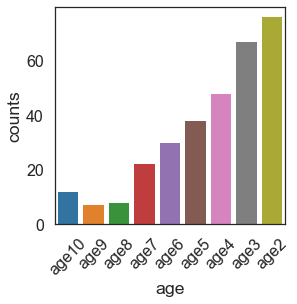

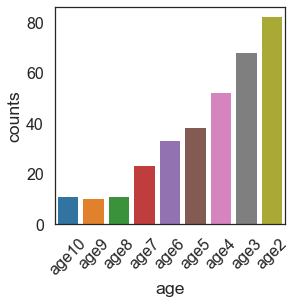

In [82]:
# df.loc[df['column_name'] == some_value]
bike = C.loc[C['category']=="a cat"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=bike,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)
    
    
couch = C.loc[C['category']=="a frog"]
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
g=sns.barplot(data=couch,x='age',y='counts')
for item in g.get_xticklabels():
    item.set_rotation(45)

### Render out images from museum station -- takes a *long* time.

In [ ]:
### Notes: It won't write out an image if it already exists. 
# Every time I get through a certain set of the  images, I record the time threshold 
#(since images are written out in chronological order)

## Time stamps every 100 images.
# [1525899407923.0,
#  1525980096385.0,
#  1526061840113.0,
#  1526072921014.0,
#  1526152365279.0,
#  1526160570739.0,
#  1526239856392.0,
#  1526251698552.0,
#  1526254954475.0,
#  1526418747635.0,
#  1526495927262.0,
#  1526503859627.0,
#  1526581190700.0,
#  1526593428928.0,
#  1526666014298.0,
#  1526680293892.0,
#  1526760285554.0,
#  1526766056162.0,
#  1527018277044.0,
#  1527793231321.0,
#  1527881543709.0,
#  1527960926822.0,
#  1527970125532.0,
#  1527977827733.0,
#  1527982709894.0,
#  1528059661642.0,
#  1528064507404.0,
#  1528068114827.0,
#  1528140581078.0,
#  1528225691857.0,
#  1528238270169.0,
#  1528321410290.0,
#  1528396097251.0,
#  1528409134891.0,
#  1528482501089.0,
#  1528492105365.0,
#  1528501366255.0,
#  1528579092501.0,
#  1528584985113.0,
#  1528661341497.0,
#  1528741749248.0,
#  1528747687974.0,
#  1528761045959.0,
#  1528835768499.0,
#  1528841240592.0,
#  1528916818096.0,
#  1528923498102.0,
#  1529005606993.0,
#  1529015740138.0,
#  1529092461367.0,
#  1529102005265.0,
#  1529178354515.0,
#  1529183429730.0,
#  1529190138056.0,
#  1529272790915.0,
#  1529351265769.0,
#  1529360098520.0,
#  1529435563121.0,
#  1529443877705.0,
#  1529518216924.0,
#  1529529413026.0,
#  1529690851878.0,
#  1529705056613.0,
#  1530311006680.0]


In [ ]:

# time_threshold = 1530650649659.0 ## first ~7000 images!
time_threshold = 1533252327962.0 ## all images up until morning of Aug 3

valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId') 
image_recs = coll.find({'$and': [{'time': {'$lt': time_threshold}}, 
                                            {'dataType':'finalImage'}]}).sort('time')    
print('we have {} valid sessions after time threshold'.format(len(valid_sessions)))
print('we have {} images after time threshold'.format(image_recs.count()))
##

In [ ]:
really_run_this=1
skipCount = 0;
writeImageCount = 0;
timeSave = []

if really_run_this:
    imsize = 224 ## img writing size, optimized for CNN
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        print('In the {} session we have {} images'.format(s,image_recs.count()))
        if image_recs.count()>3:
            for imrec in image_recs:                                                            
                category_dir = os.path.join(sketch_dir,imrec['category'])
                if not os.path.exists(category_dir):
                    os.makedirs(category_dir)
                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
                if os.path.isfile(fname):
                    ## skip this image!
                    skipCount = skipCount + 1;
                    if np.mod(skipCount,40)==0:
                        print('Weve skipped {} images...'.format(skipCount))
                        timeSave.append(imrec['time']) # we're writing out in order of time, so we can save these thresholds to be more efficeint later
                else:
                    stroke_recs = this_collection.find({'$and': [{'sessionId':s}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')   
                    if stroke_recs.count() > 0 and imrec['age']!='adult':
                        imgData = imrec['imgData'];
                        writeImageCount = writeImageCount+1
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))   
                        if np.mod(writeImageCount,10)==0:
                            print('Weve written {} images...'.format(writeImageCount))
                            timeSave.append(imrec['endTrialTime'])

In the cdm_run_v41536107048139 session we have 2 images
In the cdm_run_v41536168964111 session we have 12 images
In the cdm_run_v41536178424927 session we have 12 images
In the cdm_run_v41536249599638 session we have 2 images
In the cdm_run_v41536254744920 session we have 2 images
In the cdm_run_v41536254851282 session we have 1 images
In the cdm_run_v41536255042960 session we have 1 images
In the cdm_run_v41536255458365 session we have 8 images
In the cdm_run_v41536256584193 session we have 11 images
Weve written 10 images...
In the cdm_run_v41536260618874 session we have 3 images
In the cdm_run_v41536261036082 session we have 4 images
Weve written 20 images...
In the cdm_run_v41536261493555 session we have 1 images
In the cdm_run_v41536263126224 session we have 2 images
In the cdm_run_v41536265227405 session we have 12 images
Weve written 30 images...
In the cdm_run_v41536265480238 session we have 1 images
In the cdm_run_v41536265687579 session we have 10 images
Weve written 40 image

### Writes out images and gets other kinds of info...

In [2]:
# really_run_this =  0
# if really_run_this:
#     ## img writing parameters
#     imsize = 224
    
#     ## desired output: a dataframe that has trials on the rows, and the following columns:
#     ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
#     ## PNG string, submission_time, submission_date
#     ## to be saved out as a nice tidy CSV
#     session_id = []
#     trial_num = []
#     category = []
#     age = []
#     num_strokes = []
#     mean_pixel_intensity = []
#     bounding_box_coords = []
#     svg = []
#     svg_times = []
#     png = []
#     submit_time = []
#     submit_date = []
#     submit_date_readable = []
#     draw_duration = []
#     filename = []
#     for s in valid_sessions:
#         this_collection = coll
#         image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
#         for imrec in image_recs:                                                            
#                 stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
#                                                   {'sessionId':s}, 
#                                                   {'dataType':'stroke'},
#                                                   {'trialNum': imrec['trialNum']}]}).sort('time')   

#                 if 'age' in imrec.keys():
#                     if imrec['age'] != 'adult':
                        
#                         os.path.isfile(path)
                        
#                         if stroke_recs.count() > 0: ## only include trials if the drawings are not blank   
                            
                           
                            
#                             session_id.append(imrec['sessionId'])        
#                             trial_num.append(imrec['trialNum']) 
#                             category.append(imrec['category'])
#                             age.append(imrec['age'])
                            
#                             png.append(imrec['imgData'])
#                             submit_time.append(imrec['time'])
#                             readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
#                             submit_date_readable.append(readadble_date)
                        
#                             submit_date.append(imrec['date'])
#                             filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
#                             num_strokes.append(stroke_recs.count())
#                             _svg = [] # this keeps track of the strokes from THIS final image
#                             _svg_times = []
#                             for strec in stroke_recs:
#                                 _svg.append(strec['svg'])
#                                 _svg_times.append(strec['time'])
#                             draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
#                             svg.append(_svg)
#                             svg_times.append(_svg_times)

#                             ## and write out image data here too
#                             imgData = imrec['imgData'];
#                             filestr = base64.b64decode(imgData)
#                             category_dir = os.path.join(sketch_dir,imrec['category'])
#                             if not os.path.exists(category_dir):
#                                 os.makedirs(category_dir)
#                             fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId']))
#                             with open(fname, "wb") as fh:
#                                 fh.write(imgData.decode('base64'))  
                        

In [61]:
# really_run_this = 1
# if really_run_this:
#     ## img writing parameters
#     imsize = 224
    
#     ## desired output: a dataframe that has trials on the rows, and the following columns:
#     ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
#     ## PNG string, submission_time, submission_date
#     ## to be saved out as a nice tidy CSV
#     session_id = []
#     trial_num = []
#     category = []
#     age = []
#     num_strokes = []
#     mean_pixel_intensity = []
#     bounding_box_coords = []
#     svg = []
#     svg_times = []
#     png = []
#     submit_time = []
#     submit_date = []
#     submit_date_readable = []
#     draw_duration = []
#     filename = []
    
#     for cat in ['a boat','a car','a cup','a dog','a fish','a house','a person','a tree']:
#         imgcount = 0
#         this_collection = coll
#         image_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, {'category':cat},{'dataType':'finalImage'}]}).sort('time')   
#         for imrec in image_recs:  
#                 if imgcount < 100:
#                     stroke_recs = this_collection.find({'$and': [{'time': {'$gt': time_threshold}}, 
#                                                       {'sessionId':imrec['sessionId']}, 
#                                                       {'dataType':'stroke'},
#                                                       {'trialNum': imrec['trialNum']}]}).sort('time')   

#                     if 'age' in imrec.keys():
#                         if imrec['age'] != 'adult':
#                             if stroke_recs.count() > 0: ## only include trials if the drawings are not blank    
#                                 imgcount += 1
#                                 session_id.append(imrec['sessionId'])        
#                                 trial_num.append(imrec['trialNum']) 
#                                 category.append(imrec['category'])
#                                 age.append(imrec['age'])

#                                 png.append(imrec['imgData'])
#                                 submit_time.append(imrec['time'])
#                                 readadble_date = datetime.datetime.fromtimestamp(imrec['time']/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f')
#                                 submit_date_readable.append(readadble_date)

#                                 submit_date.append(imrec['date'])
#                                 filename.append(os.path.join(sketch_dir,'{}_{}.png'.format(imrec['category'], imgcount)))
#                                 num_strokes.append(stroke_recs.count())
#                                 _svg = [] # this keeps track of the strokes from THIS final image
#                                 _svg_times = []
#                                 for strec in stroke_recs:
#                                     _svg.append(strec['svg'])
#                                     _svg_times.append(strec['time'])
#                                 draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
#                                 svg.append(_svg)
#                                 svg_times.append(_svg_times)

#                                 ## and write out image data here too
#                                 imgData = imrec['imgData'];
#                                 filestr = base64.b64decode(imgData)
#                                 category_dir = os.path.join(sketch_dir,imrec['category'])
#                                 if not os.path.exists(category_dir):
#                                     os.makedirs(category_dir)
#                                 fname = os.path.join(category_dir,'{}_{}.png'.format(imrec['category'],imgcount))
#                                 with open(fname, "wb") as fh:
#                                     fh.write(imgData.decode('base64'))  


In [ ]:
# submit_date_readable[-100]

In [62]:
# if really_run_this:
#     X = pd.DataFrame([category,age,num_strokes,filename])
#     X = X.transpose()
#     X.columns = ['category','age','num_strokes', 'filename']
#     X.to_csv("scribble_annotate.csv")

In [ ]:
# if really_run_this:
#     X_out = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,draw_duration,filename])
#     X_out = X_out.transpose()
#     X_out.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','draw_duration', 'filename']

#     X_out.to_csv('May31th_usage.csv')

In [ ]:
# def get_bounding_box(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# merged_experiment_name = 'E1cd'

# if really_run_this:

#     ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
#     mean_intensity = []
#     bounding_box = []
#     imsize = 100
#     numpix = imsize**2
#     thresh = 250
#     for i,_d in X.iterrows():
#         imgData = _d['png']
#         filestr = base64.b64decode(imgData)
#         fname = os.path.join('sketch.png')
#         with open(fname, "wb") as fh:
#             fh.write(imgData.decode('base64'))
#         im = Image.open(fname).resize((imsize,imsize))
#         _im = np.array(im)
#         mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
#         # bounding box part
#         rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
#         bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

#     ## add to dataframe    
#     X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
#     X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
#     # save out csv
#     if not os.path.exists('../preprocessed_data'):
#         os.makedirs('../preprocessed_data')
#     X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(merged_experiment_name))


()

### load drawing metadata csv back in

In [ ]:
plt.hist(X.age,normed=False)
plt.xticks(rotation=90)
len(X.age)
sum(X.age != 'adult')

### Basic visualizations

In [ ]:
np.sum(X.draw_duration.values>25)

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [ ]:
X.category

In [ ]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

In [ ]:
X.

In [ ]:
unique

NameError: name 'os' is not defined